In [1]:
import numpy as np
from sklearn.manifold import TSNE
import cv2
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sb
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D

##Evaluation Functions

In [2]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot(x, colors):
    palette = np.array(sb.color_palette("hls", 10))  
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    txts = []
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=30)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    return f, ax, txts

##Load Train and Validation Data 

In [3]:
def load_image(imdir): 
    ext = ['png', 'jpg', 'bmp'] 
    files = [] 
    [files.extend(glob.glob(imdir + '*.' + e)) for e in ext] 
    images = [cv2.imread(file) for file in files] 
    resize_img = [] 
    for img in images: 
      resize_img.append(cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)) 
    return np.array(resize_img) 
 
#train data 
Dir=[] 
for name in os.listdir("squares/train/"):  
        path= os.path.join ("squares/train/", name)    
        if os.path.isdir(path): 
            Dir.append(name) 
Dir=sorted(Dir) 
 
train_img=[] 
train_label=[] 
i=0 
for entry in Dir: 
      train_data = load_image("squares/train/" + entry +"/") 
      if i==0: 
         train_img = train_data 
         train_label = i*np.ones(len(train_data)) 
      else: 
         train_img = np.concatenate([train_img,train_data],0) 
         train_label = np.concatenate([train_label,i*np.ones(len(train_data))],0) 
      i+=1 
dataset_size = train_img.shape[0] 
train_image = train_img.reshape(dataset_size,-1) 
 
#validation data 
Dir=[] 
for name in os.listdir("squares/val/"):  
        path= os.path.join ("squares/val/", name)    
        if os.path.isdir(path): 
            Dir.append(name) 
Dir=sorted(Dir) 
 
val_img=[] 
val_label=[] 
i=0 
for entry in Dir: 
      var_data = load_image("squares/val/" + entry +"/") 
      if i==0: 
         val_img = var_data 
         val_label = i*np.ones(len(var_data)) 
      else: 
         val_img = np.concatenate([val_img,var_data],0) 
         val_label = np.concatenate([val_label,i*np.ones(len(var_data))],0) 
      i+=1 
dataset_size = val_img.shape[0] 
val_image = val_img.reshape(dataset_size,-1)

###Exploring the training dataset using PCA analysis

['a', 'b', 'c']


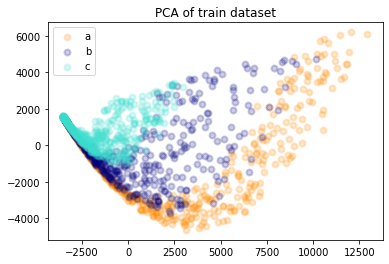

In [4]:
target_names = Dir
print(Dir)
pca = PCA(n_components=2)
train_pca = pca.fit(train_image).transform(train_image)

plt.figure()
colors = [ "darkorange","navy", "turquoise"]
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        train_pca[train_label == i, 0], train_pca[train_label == i, 1], color=color, alpha=0.2, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of train dataset")
plt.show()

###Exploring the validation dataset using PCA analysis

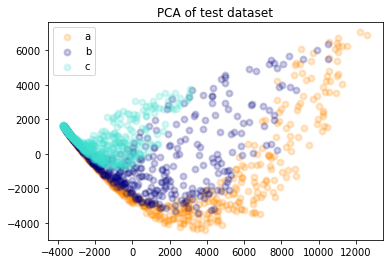

In [5]:
pca = PCA(n_components=2)
val_pca = pca.fit(val_image).transform(val_image)

plt.figure()
colors = [ "darkorange","navy", "turquoise"]
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        val_pca[val_label == i, 0], val_pca[val_label == i, 1], color=color, alpha=0.2, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of test dataset")
plt.show()

##KNN Classifier

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       500
         1.0       0.99      0.92      0.95       500
         2.0       0.97      1.00      0.98       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

Normalized confusion matrix


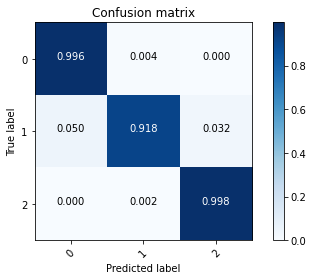

In [6]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_image,train_label)

print(classification_report(val_label, neigh.predict(val_image)))
cnf_matrix = confusion_matrix(val_label, neigh.predict(val_image))
plot_confusion_matrix(cnf_matrix, [0,1,2],normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)

##Random Forest Classifer

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       500
         1.0       0.99      0.96      0.98       500
         2.0       0.99      1.00      0.99       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

Normalized confusion matrix


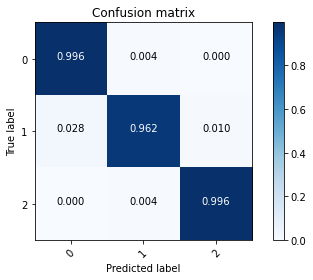

In [7]:
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(train_image, train_label)
print(classification_report(val_label, clf.predict(val_image)))
cnf_matrix = confusion_matrix(val_label, clf.predict(val_image))
plot_confusion_matrix(cnf_matrix, [0,1,2],normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)

###Visualization of false alarms

Row 278 has been classified as  1.0 and should be  0.0
Row 376 has been classified as  1.0 and should be  0.0
Row 527 has been classified as  0.0 and should be  1.0
Row 562 has been classified as  0.0 and should be  1.0
Row 609 has been classified as  0.0 and should be  1.0
Row 674 has been classified as  2.0 and should be  1.0
Row 679 has been classified as  0.0 and should be  1.0
Row 684 has been classified as  0.0 and should be  1.0
Row 688 has been classified as  0.0 and should be  1.0
Row 712 has been classified as  0.0 and should be  1.0
Row 736 has been classified as  2.0 and should be  1.0
Row 746 has been classified as  2.0 and should be  1.0
Row 756 has been classified as  0.0 and should be  1.0
Row 778 has been classified as  0.0 and should be  1.0
Row 810 has been classified as  0.0 and should be  1.0
Row 813 has been classified as  2.0 and should be  1.0
Row 849 has been classified as  0.0 and should be  1.0
Row 890 has been classified as  2.0 and should be  1.0
Row 921 ha

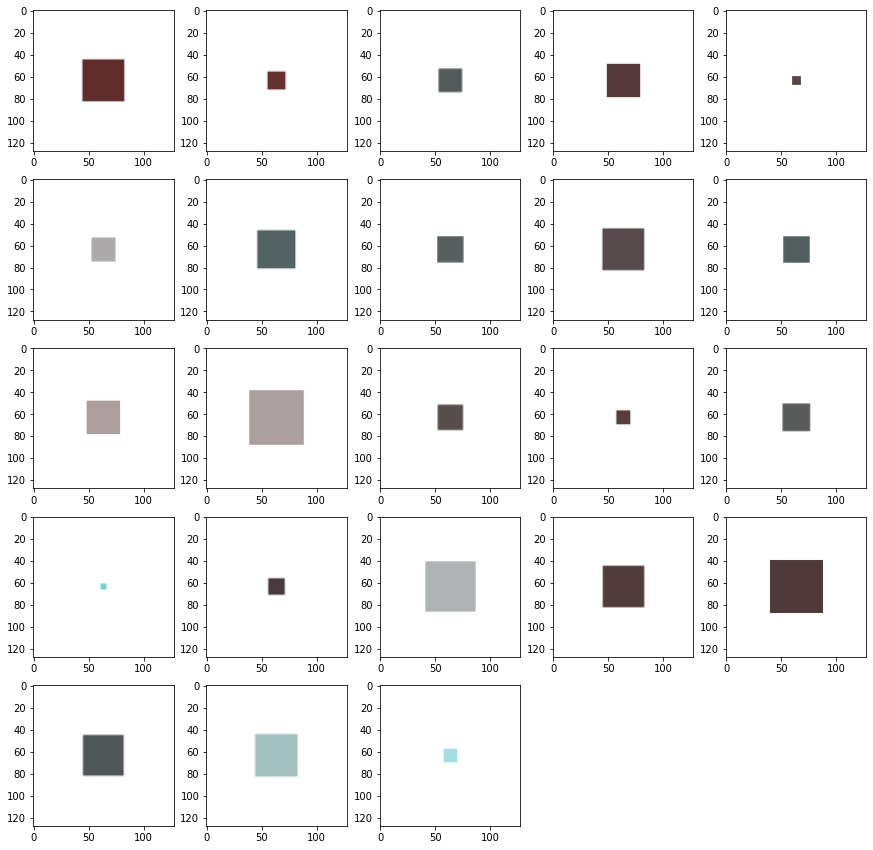

In [8]:
row=[]
for row_index, (input, prediction, label) in enumerate(zip (val_img, clf.predict(val_image), val_label)):
  if prediction != label:
    print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
    row.append(row_index)

plt.figure(figsize=(15,15)) 
for i in range(len(row)):
    plt.subplot(5,5,i+1)    
    plt.imshow(val_img[row[i],:,:,:])
plt.show()